## Import

In [19]:
from pathlib import Path
from datetime import datetime
import random
import pandas as pd
import numpy as np
import os
import re
import glob
import cv2
import PIL.Image as Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torchvision.models as models
from transformers import ViTForImageClassification

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from tqdm.auto import tqdm

import warnings
warnings.filterwarnings(action='ignore') 

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

## Hyperparameter Setting

In [51]:
CFG = {
    'MODEL_NAME':'ViT',
    'DATA_PATH':Path(r'F:\datasets\dacon\hansol'),
    'IMG_SIZE':224,
    'EPOCHS':10,
    'LEARNING_RATE':3e-4,
    'BATCH_SIZE':16,
    'SEED':41
}
train_path =CFG['DATA_PATH'] / 'train'
test_path = CFG['DATA_PATH'] / 'test'

## Fixed RandomSeed

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

In [5]:
def rename_folder():
    """
    한글 폴더 명 0~n_classes 변경
    """
    folder_dict ={id:label for id,label in enumerate(os.listdir(train_path))}
    os.chdir(train_path)
    for old_folder_name in os.listdir(train_path):
        if old_folder_name in folder_dict.values():
            new_folder_name = str(list(folder_dict.keys())[list(folder_dict.values()).index(old_folder_name)])
            # print(old_folder_name,new_folder_name)
            os.rename(old_folder_name, new_folder_name)
folder_dict = {0: '가구수정',
               1: '걸레받이수정',
               2: '곰팡이',
               3: '꼬임',
               4: '녹오염',
               5: '들뜸',
               6: '면불량',
               7: '몰딩수정',
               8: '반점',
               9: '석고수정',
               10: '오염',
               11: '오타공',
               12: '울음',
               13: '이음부불량',
               14: '창틀,문틀수정',
               15: '터짐',
               16: '틈새과다',
               17: '피스',
               18: '훼손'}

## Data Pre-processing

In [6]:
# './train/*/*'
all_img_list = glob.glob(str(CFG['DATA_PATH'] / 'train/*/*'))

In [7]:
df = pd.DataFrame(columns=['img_path', 'label'])
df['img_path'] = all_img_list
df['label'] = df['img_path'].apply(lambda x : str(x).split('\\')[-2])

In [8]:
train_df, val, _, _ = train_test_split(df, df['label'], test_size=0.3, stratify=df['label'], random_state=CFG['SEED'])

<AxesSubplot: >

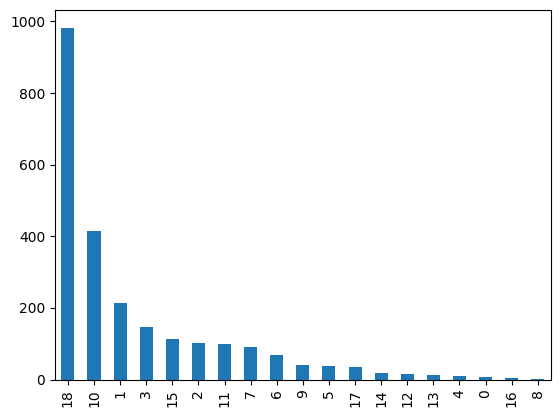

In [9]:

train_df['label'].value_counts().plot(kind='bar')

<AxesSubplot: >

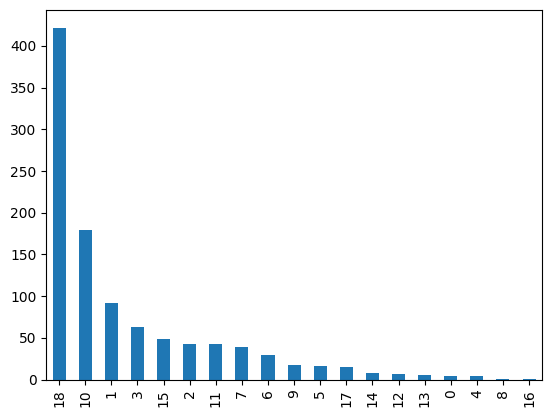

In [10]:
val['label'].value_counts().plot(kind='bar')

## CustomDataset

In [11]:
class CustomDataset(Dataset):
    def __init__(self, img_path_list, label_list, transforms=None):
        self.img_path_list = img_path_list
        self.label_list = label_list
        self.transforms = transforms
        
    def __getitem__(self, index):
        img_path = self.img_path_list[index]
        
        image = cv2.imread(img_path)
        
        if self.transforms is not None:
            image = self.transforms(image=image)['image']
        
        if self.label_list is not None:
            label = self.label_list[index]
            return image, label
        else:
            return image
        
    def __len__(self):
        return len(self.img_path_list)

class CustomDataset_2(Dataset):
    def __init__(self, img_path_list, label_list, transforms=None):
        self.img_path_list = img_path_list
        self.label_list = [int(l) for l in label_list] if label_list is not None else None
        self.transforms = transforms
        self.feature = []

        for img_path in tqdm(self.img_path_list):
            # TODO: RGB, BGR 각각 실험
            image = (cv2.cvtColor(cv2.imread(img_path),cv2.COLOR_BGR2RGB) )
            if self.transforms is not None:
                image = self.transforms(image=image)['image']
            self.feature.append(image)

    def __getitem__(self, index):
        if self.label_list is not None:
            return self.feature[index], self.label_list[index]
        else:
            return self.feature[index]
        
    def __len__(self):
        return len(self.img_path_list)
# c= CustomDataset(df['img_path'],df['label'])


In [12]:
train_transform = A.Compose([
                            A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
                            ToTensorV2()
                            ])

test_transform = A.Compose([
                            A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
                            ToTensorV2()
                            ])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


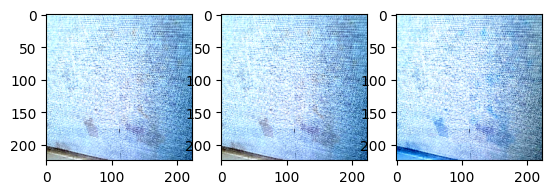

In [13]:
import matplotlib.pyplot as plt
plt.subplot(1,3,1)
plt.imshow(train_transform(image = np.array(Image.open(df['img_path'].iloc[456])))['image'].permute(1,2,0).numpy())
plt.subplot(1,3,2)
plt.imshow(train_transform(image = np.array(cv2.cvtColor(cv2.imread(df['img_path'].iloc[456]),cv2.COLOR_BGR2RGB) ))['image'].permute(1,2,0).numpy())
plt.subplot(1,3,3)
plt.imshow(train_transform(image = np.array(cv2.imread(df['img_path'].iloc[456])))['image'].permute(1,2,0).numpy())

In [14]:
train_dataset = CustomDataset_2(train_df['img_path'].values, train_df['label'].values, train_transform)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

val_dataset = CustomDataset_2(val['img_path'].values, val['label'].values, test_transform)
val_loader = DataLoader(val_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

  0%|          | 0/2419 [00:00<?, ?it/s]

  0%|          | 0/1038 [00:00<?, ?it/s]

## Model Define

In [59]:
class BaseModel(nn.Module):
    def __init__(self, num_classes=len(df['label'].unique())):
        super(BaseModel, self).__init__()
        self.backbone = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224', num_labels=num_classes,ignore_mismatched_sizes=True)
        #model = models.efficientnet_b0(pretrained=True)
        for param in self.backbone.parameters():
            param.requires_grad = True

        for param in self.backbone.classifier.parameters():
            param.requires_grad = True
        
    def forward(self, x):
        x = self.backbone(x)
        return x.logits

## Train

In [60]:
def train(model, optimizer, train_loader, val_loader, scheduler, device):
    model.to(device)
    criterion = nn.CrossEntropyLoss().to(device)
    
    best_score = 0
    best_model = None
    
    for epoch in range(1, CFG['EPOCHS']+1):
        model.train()
        train_loss = []
        for imgs, labels in tqdm(train_loader):
            imgs = imgs.float().to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            output = model(imgs)
            loss = criterion(output, labels)
            
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
                    
        _val_loss, _val_score = validation(model, criterion, val_loader, device)
        _train_loss = np.mean(train_loss)
        print(f'Epoch [{epoch}], Train Loss : [{_train_loss:.5f}] Val Loss : [{_val_loss:.5f}] Val Weighted F1 Score : [{_val_score:.5f}]')
       
        if scheduler is not None:
            scheduler.step(_val_score)
            
        if best_score < _val_score:
            best_score = _val_score
            best_model = model
    
    return best_model

In [61]:
def validation(model, criterion, val_loader, device,return_lists=False):
    model.eval()
    val_loss = []
    preds, true_labels = [], []

    with torch.no_grad():
        for imgs, labels in tqdm(val_loader):
            imgs = imgs.float().to(device)
            labels = labels.to(device)
            
            pred = model(imgs)
            
            loss = criterion(pred, labels)
            
            preds += pred.argmax(1).detach().cpu().numpy().tolist()
            true_labels += labels.detach().cpu().numpy().tolist()
            
            val_loss.append(loss.item())
        
        _val_loss = np.mean(val_loss)
        _val_score = f1_score(true_labels, preds, average='weighted')
    if return_lists:
        return true_labels, preds
    else:
        return _val_loss, _val_score

## Run!!

In [62]:
model = BaseModel()
model.eval()
optimizer = torch.optim.Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, threshold_mode='abs', min_lr=1e-8, verbose=True)

infer_model = train(model, optimizer, train_loader, val_loader, scheduler, device)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([19, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([19]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch [1], Train Loss : [1.41593] Val Loss : [1.15858] Val Weighted F1 Score : [0.58614]


  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.81685] Val Loss : [1.13094] Val Weighted F1 Score : [0.63559]


  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.50549] Val Loss : [1.05226] Val Weighted F1 Score : [0.67193]


  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.42749] Val Loss : [1.14961] Val Weighted F1 Score : [0.63934]


  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.32434] Val Loss : [1.51637] Val Weighted F1 Score : [0.57995]


  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.25519] Val Loss : [1.48079] Val Weighted F1 Score : [0.62621]
Epoch 00006: reducing learning rate of group 0 to 1.5000e-04.


  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.09578] Val Loss : [1.09358] Val Weighted F1 Score : [0.72099]


  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.02871] Val Loss : [1.07208] Val Weighted F1 Score : [0.74915]


  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.01873] Val Loss : [1.28003] Val Weighted F1 Score : [0.70610]


  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.02264] Val Loss : [1.13219] Val Weighted F1 Score : [0.74608]


In [65]:
infer_model = train(model, optimizer, train_loader, val_loader, scheduler, device)

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.00529] Val Loss : [1.15845] Val Weighted F1 Score : [0.74348]
Epoch 00011: reducing learning rate of group 0 to 7.5000e-05.


  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.00168] Val Loss : [1.16188] Val Weighted F1 Score : [0.74636]


  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.00090] Val Loss : [1.17490] Val Weighted F1 Score : [0.74654]


  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.00075] Val Loss : [1.18674] Val Weighted F1 Score : [0.74965]


  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.00066] Val Loss : [1.19797] Val Weighted F1 Score : [0.75052]


  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.00058] Val Loss : [1.20903] Val Weighted F1 Score : [0.74931]


  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.00052] Val Loss : [1.22028] Val Weighted F1 Score : [0.75031]


  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.00046] Val Loss : [1.23216] Val Weighted F1 Score : [0.74931]
Epoch 00018: reducing learning rate of group 0 to 3.7500e-05.


  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.00042] Val Loss : [1.23868] Val Weighted F1 Score : [0.74922]


  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.00040] Val Loss : [1.24575] Val Weighted F1 Score : [0.74835]


In [68]:
infer_model = train(model, optimizer, train_loader, val_loader, scheduler, device)

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.00038] Val Loss : [1.25342] Val Weighted F1 Score : [0.74835]
Epoch 00021: reducing learning rate of group 0 to 1.8750e-05.


  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.00036] Val Loss : [1.25754] Val Weighted F1 Score : [0.74835]


  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.00035] Val Loss : [1.26189] Val Weighted F1 Score : [0.74835]


  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.00034] Val Loss : [1.26644] Val Weighted F1 Score : [0.74835]
Epoch 00024: reducing learning rate of group 0 to 9.3750e-06.


  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.00033] Val Loss : [1.26882] Val Weighted F1 Score : [0.74835]


  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.00033] Val Loss : [1.27131] Val Weighted F1 Score : [0.74835]


  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.00032] Val Loss : [1.27390] Val Weighted F1 Score : [0.74835]
Epoch 00027: reducing learning rate of group 0 to 4.6875e-06.


  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.00031] Val Loss : [1.27526] Val Weighted F1 Score : [0.74835]


  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.00031] Val Loss : [1.27667] Val Weighted F1 Score : [0.74835]


  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.00031] Val Loss : [1.27816] Val Weighted F1 Score : [0.74835]
Epoch 00030: reducing learning rate of group 0 to 2.3437e-06.


In [69]:
true_labels, preds = validation(infer_model, nn.CrossEntropyLoss(),val_loader, device,True)

  0%|          | 0/65 [00:00<?, ?it/s]

In [67]:
print(classification_report(true_labels,preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.94      0.88      0.91        92
           2       0.82      0.77      0.80        43
           3       0.90      0.89      0.90        63
           4       1.00      0.50      0.67         4
           5       0.85      0.69      0.76        16
           6       0.67      0.27      0.38        30
           7       0.67      0.67      0.67        39
           8       0.00      0.00      0.00         1
           9       0.70      0.41      0.52        17
          10       0.66      0.66      0.66       179
          11       0.72      0.77      0.74        43
          12       0.00      0.00      0.00         7
          13       1.00      0.60      0.75         5
          14       0.40      0.25      0.31         8
          15       0.87      0.84      0.85        49
          16       0.00      0.00      0.00         1
          17       0.73    

In [70]:
print(classification_report(true_labels,preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.94      0.88      0.91        92
           2       0.82      0.77      0.80        43
           3       0.90      0.89      0.90        63
           4       1.00      0.50      0.67         4
           5       0.85      0.69      0.76        16
           6       0.67      0.27      0.38        30
           7       0.67      0.67      0.67        39
           8       0.00      0.00      0.00         1
           9       0.70      0.41      0.52        17
          10       0.66      0.66      0.66       179
          11       0.72      0.77      0.74        43
          12       0.00      0.00      0.00         7
          13       1.00      0.60      0.75         5
          14       0.40      0.25      0.31         8
          15       0.87      0.84      0.85        49
          16       0.00      0.00      0.00         1
          17       0.73    

## Inference

In [71]:
test_dataset = CustomDataset_2([str(test_path / file) for file in os.listdir(test_path)], None, test_transform)
test_loader = DataLoader(test_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

  0%|          | 0/792 [00:00<?, ?it/s]

In [72]:
def inverse_transform(preds):
    return np.array([folder_dict[pred] for pred in preds])

In [73]:
def inference(model, test_loader, device):
    model.eval()
    preds = []
    with torch.no_grad():
        for imgs in tqdm(iter(test_loader)):
            imgs = imgs.float().to(device)
            
            pred = model(imgs)
            
            preds += pred.argmax(1).detach().cpu().numpy().tolist()
    
    preds = inverse_transform(preds)
    return preds

In [74]:
preds = inference(infer_model, test_loader, device)

  0%|          | 0/50 [00:00<?, ?it/s]

## Submission

In [75]:
submit = pd.read_csv(CFG['DATA_PATH'] / 'sample_submission.csv')
submit['label'] = preds

In [76]:
current_datetime = datetime.now()
formatted_datetime = current_datetime.strftime("%Y_%m_%d_%H_%M")
os.makedirs('./result',exist_ok=True)
submit.to_csv(f'./result/{CFG["MODEL_NAME"]}_{formatted_datetime}.csv', index=False)

<AxesSubplot: >

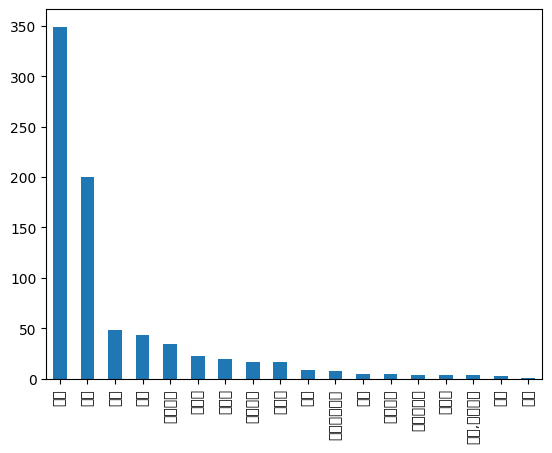

In [77]:
submit['label'].value_counts().plot(kind='bar')